In [1]:
import sys

from src.model.negbinautoencoder import *
import scanpy as sc

from sklearn.model_selection import train_test_split
import time
from captum.attr import GradientShap
from src.model.inferrence_simple import *
from src.utils.data_utils import attribution_to_anndata
import src.downstream.downstream as d

ModuleNotFoundError: No module named 'src'

In [ ]:
import os
folders = [os.path.join(r, d) + "/" for r, d, _ in os.walk("/home/baz8031/NetMap/2025/2/benchmark/data/perturb_seq") for d in d]
print(folders)

[]


: 

: 

In [ ]:
case = folders[6]

IndexError: list index out of range

: 

: 

In [ ]:
print(f"case: {case}")
print("\n")

case_ = os.path.basename(os.path.normpath(case))
case_ = case_.split("_")
#net_gt_1 = pd.read_csv(f'{case}{case_[0]}_network_wilcoxon_no_pb.csv')
#net_gt_2 = pd.read_csv(f'{case}{case_[1]}_network_wilcoxon_no_pb.csv')
#print(f"Size GT NET 1 : {net_gt_1.shape}")
#print(f"Size GT NET 1 : {net_gt_2.shape}")

case: /home/baz8031/NetMap/2025/2/benchmark/data/perturb_seq/CEBPA_CEBPE/




: 

: 

In [2]:
import sys
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/netmap')

from src.utils.netmap_config import NetmapConfig

In [3]:
NetmapConfig.learning_rate

0.005

In [ ]:

config = NetmapConfig.read_yaml(yaml_file="/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/netmap/")
net = pd.read_csv('/data_nfs/og86asub/netmap/NetMap_LRP/benchmark/data/simulated_data/config_ro/net_63_4684/net.tsv', sep = '\t')


{'input_data': '/data_nfs/og86asub/netmap/NetMap_LRP/benchmark/data/perturb_seq/CEBPA_KLF1/data.h5ad', 'tf_only': False, 'transcription_factors': '/data_nfs/datasets/SCENIC_DB/tf_lists/allTFs_hg38.txt', 'gene_1': 'CEBPA', 'gene_2': 'KLF1', 'network_1': '/data_nfs/og86asub/netmap/NetMap_LRP/benchmark/data/perturb_seq/CEBPA_KLF1/CEBPA_network.csv', 'network_2': '/data_nfs/og86asub/netmap/NetMap_LRP/benchmark/data/perturb_seq/CEBPA_KLF1/KLF1_network.csv', 'edge_count': 10000, 'penalize_error': True, 'adata_filename': 'grn_lrp.h5ad', 'grn': 'grn_lrp.tsv', 'output_directory': '/data_nfs/og86asub/netmap/NetMap_LRP/benchmark/results/perturb_seq/CEBPA_KLF1', 'overwrite': True, 'epochs': 1000, 'learning_rate': 0.005, 'masking_percentage': 0.1, 'masking_value': 0, 'optimizer': 'Adam', 'print_every': 100, 'test_size': 0.3}


TypeError: NetmapConfig.__init__() got an unexpected keyword argument 'gene_1'

In [ ]:
## load data
#eval_config = read_config('/home/baz8031/NetMap/2025/4/NetMap_LRP/evaluation/configurations/netmap/eval_config.yaml')

collectri = pd.read_csv('benchmark/data/input_network/collectri_2024-11-11.tsv', sep='\t')
net_1 = pd.read_csv(f'{case}{case_[0]}_network_DE_DESeq2_and_NO_pb.csv')
net_2 = pd.read_csv(f'{case}{case_[1]}_network_DE_DESeq2_and_NO_pb.csv')


#collectri = pd.read_csv('benchmark/data/input_network/collectri_2024-11-11.tsv', sep='\t')
#nn = pd.read_csv(config['evaluation']['network_1'])
#nn2 = pd.read_csv(config['evaluation']['network_2'])

#result_dict = {'gene_1': config['evaluation']['gene_1']}
#result_dict['gene_2'] =  config['evaluation']['gene_2']


## load data
adata_full = sc.read_h5ad('/home/baz8031/NetMap/perturb-seq/Now/perterb-seq-main-raw.h5ad')

TypeError: NetmapConfig.__init__() got an unexpected keyword argument 'data'

: 

: 

: 

: 

In [ ]:
adata = adata_full[adata_full.obs.guide_identity.isin([f'{case_[0]}_NegCtrl0', f'{case_[1]}_NegCtrl0'])].copy()
adata.obs['guide_identity'][adata.obs['guide_identity']!=f'{case_[1]}_NegCtrl0']= f'{case_[0]}_NegCtrl0'

adata.layers['counts'] = adata.X
#sc.pp.normalize_total(adata)
#adata.raw = adata

: 

: 

In [ ]:
adata.var_names_make_unique()
adata = adata[adata.obs.good_coverage].copy()
adata = adata[adata.obs.number_of_cells == 1]
sc.pp.normalize_total(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)

: 

: 

In [ ]:
gene_names = np.array(adata.var.index)

: 

: 

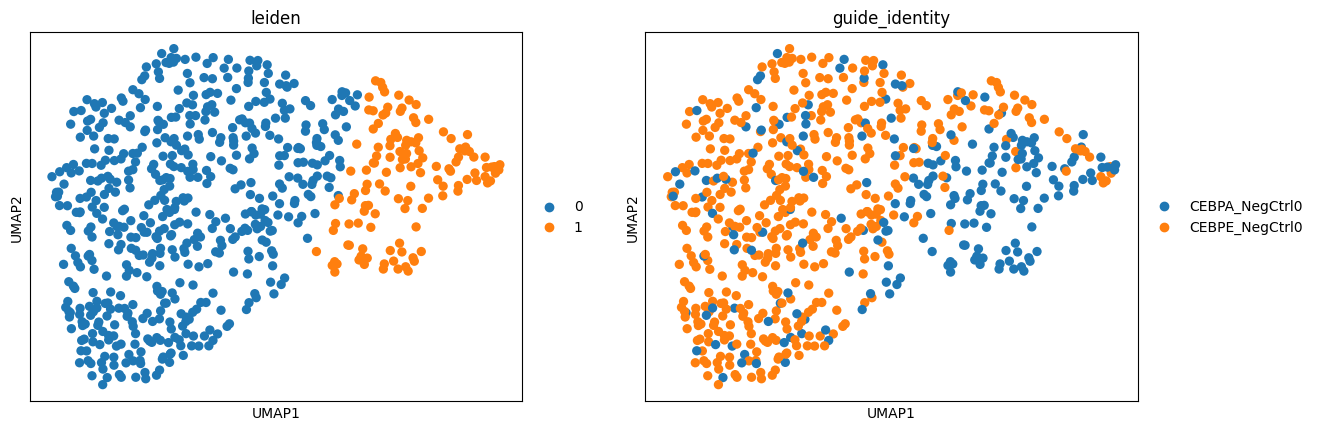

: 

: 

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['leiden', 'guide_identity'])

In [ ]:
import pandas as pd

sc.tl.rank_genes_groups(adata, groupby='guide_identity', method='wilcoxon') 
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Collect top N DEGs for each group
top_n = 100
degs = {
    group: pd.DataFrame({
        'names': result['names'][group][:top_n],
        'logfoldchanges': result['logfoldchanges'][group][:top_n],
        'pvals_adj': result['pvals_adj'][group][:top_n]
    })
    for group in groups
}

gt_nets = []
for k in degs.keys():
    print(k.split("_")[0])
    print(list(degs[k]["names"]))

    edges = [(k.split("_")[0], gene) for gene in list(degs[k]["names"])]
    network_df = pd.DataFrame(edges, columns=["source", "target"])
    gt_nets.append(network_df)




CEBPA
['TMSB4X', 'TPT1', 'CSF3R', 'CFD', 'METTL9', 'NCF1', 'LST1', 'TYROBP', 'CORO1A', 'SH3BGRL3', 'S100A11', 'MALAT1', 'ARPC5', 'FTL', 'ARHGDIB', 'CEBPA', 'ARPC1B', 'SRGN', 'ITM2B', 'SERPINB1', 'MSRB1', 'CYBA', 'FCER1G', 'PLD3', 'COMMD6', 'C10orf54', 'MS4A3', 'PNRC1', 'GLRX', 'BRI3', 'RP11-301G19.1', 'TPM4', 'VIM', 'TXNIP', 'MARCKSL1', 'TKT', 'DBI', 'LGALS1', 'CLC', 'LYZ', 'ATP6V0E1', 'FCGRT', 'SAT1', 'GSN', 'FAM101B', 'LAPTM5', 'BTG1', 'GPSM3', 'RCSD1', 'MYO1F', 'GLIPR1', 'MYL12A', 'PPP1R18', 'PGD', 'YPEL3', 'FTH1', 'TNFAIP8', 'AIF1', 'P4HB', 'CLU', 'EVI2B', 'PLEK', 'SPI1', 'ALAS1', 'SKAP2', 'APLP2', 'HP', 'COTL1', 'CD52', 'HVCN1', 'SLC44A1', 'SH3BGRL', 'MSN', 'HEPH', 'CD37', 'N4BP2L2', 'PRG2', 'JAML', 'PRKCB', 'RNF130', 'COL9A2', 'LPCAT2', 'CCPG1', 'CREG1', 'ACAA1', 'IRF2BP2', 'PTPN7', 'CD84', 'TNFSF10', 'NEU1', 'ORAI3', 'TRPM4', 'ITGB2', 'PLAUR', 'TMEM219', 'RP6-159A1.4', 'MNDA', 'GMFG', 'NCOA4', 'ACSL1']
CEBPE
['RPS2', 'MT-ND2', 'MDK', 'RPS6', 'CEBPE', 'RPL3', 'MT-ND1', 'NME1', 'Y

: 

: 

In [ ]:
net_gt_1 = gt_nets[0]
net_gt_1.head()

,source,target
0,CEBPA,TMSB4X
1,CEBPA,TPT1
2,CEBPA,CSF3R
3,CEBPA,CFD
4,CEBPA,METTL9


: 

: 

In [ ]:
net_gt_2 = gt_nets[1]
net_gt_2.head()

,source,target
0,CEBPE,RPS2
1,CEBPE,MT-ND2
2,CEBPE,MDK
3,CEBPE,RPS6
4,CEBPE,CEBPE


: 

: 

In [ ]:
adata

AnnData object with n_obs × n_vars = 669 × 2000
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden'
    var: 'Ensembl_ids', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'guide_identity_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

: 

: 

In [ ]:
def create_model_zoo(data_tensor, n_models = 4):
    model_zoo = []
    for _ in range(n_models):


        start = time.monotonic()
        data_train2, data_test2 = train_test_split(data_tensor,test_size=0.95, shuffle=True)

        trained_model2 = NegativeBinomialAutoencoder(input_dim=data_tensor.shape[1], latent_dim=10, dropout_rate = 0.25)
        trained_model2 = trained_model2.cuda()

        optimizer2 = torch.optim.Adam(trained_model2.parameters(), lr=1e-4)

        trained_model2 = train_autoencoder(
                trained_model2,
                data_train2.cuda(),
                optimizer2,
                num_epochs=3000

            )
        model_zoo.append(trained_model2)
    return model_zoo



: 

: 

In [ ]:

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import HDBSCAN


def set_latent_true(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = True
    return model_zoo


def set_all_false(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo


def pair_cooccurence(u, v):
  u_arr = np.array(u)
  v_arr = np.array(v)
  term1 = np.sum(u_arr-v_arr!=0)
  return term1 / len(u_arr)


: 

: 

In [ ]:
def compute_consensus_clustering(model_zoo, data_tensor):
    model_zoo = set_latent_true(model_zoo)
    clusterings = {}
    for m in range(len(model_zoo)):
        latent = model_zoo[m](data_tensor.cuda())
        latent = sc.AnnData(latent.detach().cpu().numpy())
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        latent.obs = adata.obs
        sc.tl.leiden(latent, resolution=0.1)
        clusterings[f'leiden_{m}'] = latent.obs[f'leiden']
        sc.pl.umap(latent, color =['guide_identity', "leiden"])
    model_zoo = set_all_false(model_zoo)

    clusterings = pd.DataFrame(clusterings)

    latent.obs = pd.concat([latent.obs, clusterings], axis=1)
    clustering = clusterings.values.astype(int) 

    pairwise_distances_flat = pdist(clustering, metric=pair_cooccurence)
    pairwise_distances_matrix = squareform(pairwise_distances_flat)

    hdb = HDBSCAN(min_cluster_size=50, metric= 'precomputed')
    hdb.fit(pairwise_distances_matrix)
    latent.obs['consensus'] = hdb.labels_


    return latent

: 

: 

In [ ]:
def set_mu_true(model_zoo):
    # forward only mu
    for mo in model_zoo:
        mo.forward_mu_only = True
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo

: 

: 

In [ ]:
def generate_background_data(model_zoo, data_tensor, latent):
    backgrounds = {}
    for i in latent.obs['consensus'].unique():
        if i!=-1:
            backgrounds[i] = []

    for m in range(len(model_zoo)):
        # Get average params over all 
        mean_theta = get_thetas(model_zoo[m], data_tensor)
        mean_mu = get_mus(model_zoo[m], data_tensor)
        samples_mean = sample_from_vectors(mean_mu, mean_theta, size=200).T


        mean_mus = get_mus_grouping(model_zoo[m], data_tensor, latent.obs['consensus'])
        mean_thetas = get_thetas_grouping(model_zoo[m], data_tensor, latent.obs['consensus'])

        for i in backgrounds.keys():
            backgrounds[i].append(sample_from_vectors(mean_mus[i], mean_thetas[i], size=200).T)

    for b in backgrounds.keys():
        backgrounds[b] = np.concatenate(backgrounds[b])
        backgrounds[b] = torch.tensor(backgrounds[b]).cuda()

    return backgrounds


: 

: 

In [ ]:

def compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, n_top = 250):
    myexplainers = [GradientShap(mo) for mo in model_zoo]
    attributions = []
    for b in backgrounds.keys():
        aggregated_attribution, nlc = inference_complete(myexplainers, data_tensor[latent.obs['consensus'] == b].cuda(), gene_names, backgrounds[b], xai_type='shap-like', num_iterations=5,n_top_genes=n_top )

        cou = pd.DataFrame(nlc)
        cou['target'] = list(np.repeat(adata.var.index, n_top))
        cou.columns = ['source', 'target']

        ad = attribution_to_anndata(aggregated_attribution, varnames=cou, obs=latent.obs[latent.obs['consensus'] == b])
        ad.var = cou
        attributions.append(ad)
    return attributions
    
    

: 

: 

In [ ]:
def concatenate_cluster_anndatas(attributions):
    for a in attributions:
        a.var_names = [f'{z[0]}_{z[1]}' for z in zip(a.var['source'], a.var['target'])]
        a.var_names = [f'{z[0]}_{z[1]}' for z in zip(a.var['source'], a.var['target'])]
    aa = sc.concat(attributions, join = 'outer')
    return aa

: 

: 

Epoch 1/3000, Loss: 1.2127
Epoch 11/3000, Loss: 1.0073
Epoch 21/3000, Loss: 0.9478
Epoch 31/3000, Loss: 0.8109
Epoch 41/3000, Loss: 0.7018
Epoch 51/3000, Loss: 0.6151
Epoch 61/3000, Loss: 0.5962
Epoch 71/3000, Loss: 0.5188
Epoch 81/3000, Loss: 0.5214
Epoch 91/3000, Loss: 0.5049
Epoch 101/3000, Loss: 0.4883
Epoch 111/3000, Loss: 0.4959
Epoch 121/3000, Loss: 0.5204
Epoch 131/3000, Loss: 0.5295
Epoch 141/3000, Loss: 0.5195
Epoch 151/3000, Loss: 0.4663
Epoch 161/3000, Loss: 0.5203
Epoch 171/3000, Loss: 0.4751
Epoch 181/3000, Loss: 0.4563
Epoch 191/3000, Loss: 0.4692
Epoch 201/3000, Loss: 0.5009
Epoch 211/3000, Loss: 0.4488
Epoch 221/3000, Loss: 0.4450
Epoch 231/3000, Loss: 0.4804
Epoch 241/3000, Loss: 0.4477
Epoch 251/3000, Loss: 0.4544
Epoch 261/3000, Loss: 0.4413
Epoch 271/3000, Loss: 0.4537
Epoch 281/3000, Loss: 0.4379
Epoch 291/3000, Loss: 0.4370
Epoch 301/3000, Loss: 0.5070
Epoch 311/3000, Loss: 0.4341
Epoch 321/3000, Loss: 0.4254
Epoch 331/3000, Loss: 0.4533
Epoch 341/3000, Loss: 0.4

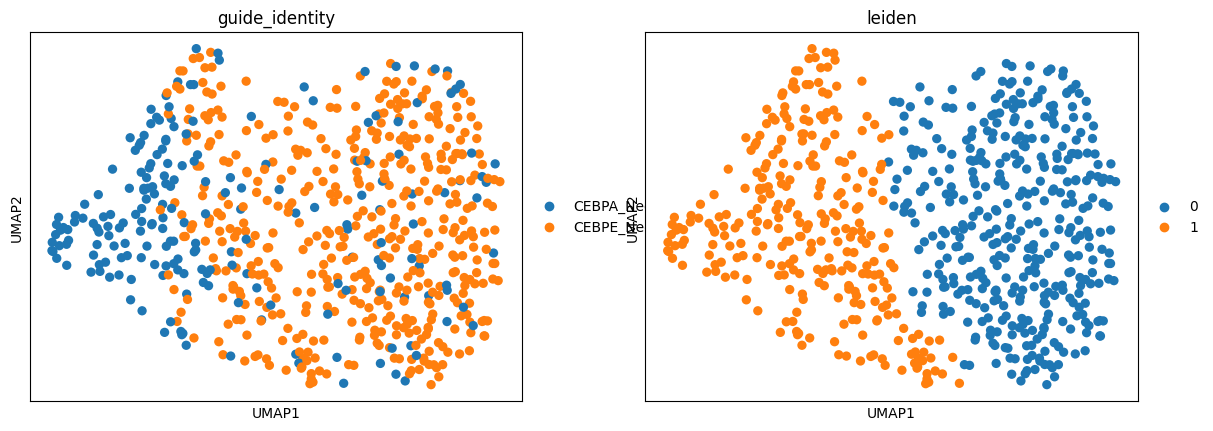

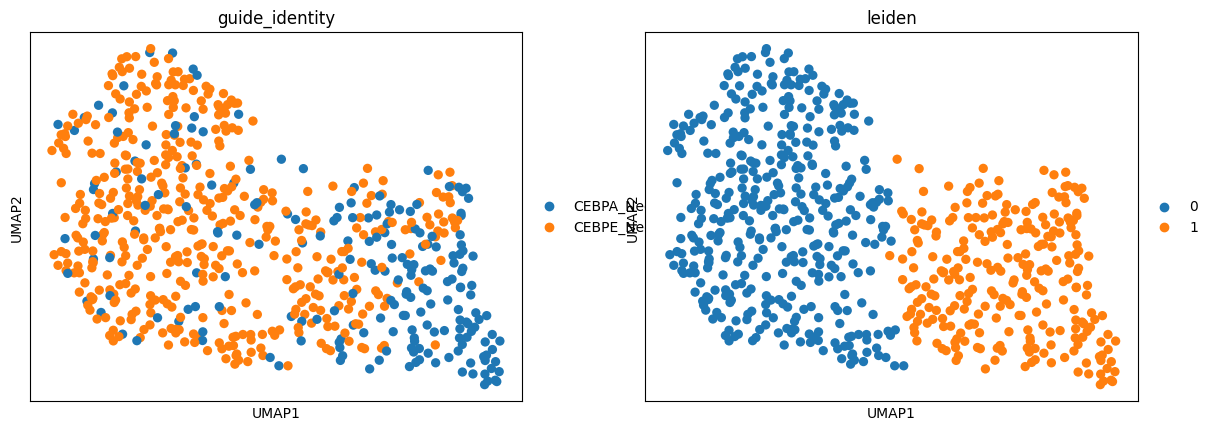

100%|██████████| 2000/2000 [02:24<00:00, 13.84it/s]


: 

: 

In [ ]:
data_tensor = torch.tensor(adata.layers['counts'].todense(), dtype=torch.float32)

model_zoo = create_model_zoo(data_tensor, n_models=2)
latent = compute_consensus_clustering(model_zoo, data_tensor)
backgrounds = generate_background_data(model_zoo, data_tensor, latent)
attributions = compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds)

In [ ]:
attributions

[AnnData object with n_obs × n_vars = 365 × 500000
     obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus'
     var: 'source', 'target',
 AnnData object with n_obs × n_vars = 243 × 500000
     obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus'
     var: 'source', 'target']

: 

: 

In [ ]:
aa = concatenate_cluster_anndatas(attributions)
aa

AnnData object with n_obs × n_vars = 608 × 686770
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus'

: 

: 

In [ ]:
aa.var["source"] = aa.var.index.str.split("_").str[0]
aa.var["target"] = aa.var.index.str.split("_").str[1]
aa.var.head(4)

,source,target
AAK1_AAK1,AAK1,AAK1
AAK1_ABCA1,AAK1,ABCA1
AAK1_ABCA10,AAK1,ABCA10
AAK1_ABCC11,AAK1,ABCC11


: 

: 

In [ ]:
print(f" Intersection with GT1 I: {pd.merge(aa.var, net_gt_1, on=['source', 'target'], how='inner').shape}")
print(f" Intersection with GT2 I: {pd.merge(aa.var, net_gt_2, on=['source', 'target'], how='inner').shape}")

 Intersection with GT1 I: (79, 2)
 Intersection with GT2 I: (100, 2)


: 

: 

: 

: 

## Downstream Main

In [ ]:
import postprocessing.downstreammain as d

: 

: 

In [ ]:
# Replace NaN values with 0 if needed

if isinstance(aa.X, np.ndarray):
    aa.X = np.nan_to_num(aa.X)
else:
    aa.X.data[np.isnan(aa.X.data)] = 0

: 

: 

In [ ]:
help(d.downstream_recipe)

Help on function downstream_recipe in module postprocessing.downstreammain:

downstream_recipe(adata, min_perc: float, n_clusters: int)
    Performs a downstream analysis on an AnnData object, including filtering, PCA, clustering, and UMAP.
    
    Parameters:
    -----------
    adata : AnnData
        The annotated data matrix.
    min_perc : float
        Minimum percentage of cells an edge must be expressed in to be retained.
    n_clusters : int
        Desired number of clusters.
    config : dict, optional
        Dictionary containing 'n_neighbors', 'leiden_resolution', 'n_components', 'knn_neighbors'. Defaults used if not provided.
    
    Returns:
    --------
    AnnData
        Updated AnnData object with PCA, clustering, and UMAP embeddings.



: 

: 

In [ ]:
aa = d.downstream_recipe(aa, min_perc=10, n_clusters=2)
aa

Removed 1994 edges (kept 684776 edges).


AnnData object with n_obs × n_vars = 608 × 684776
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus'
    var: 'source', 'target', 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

: 

: 

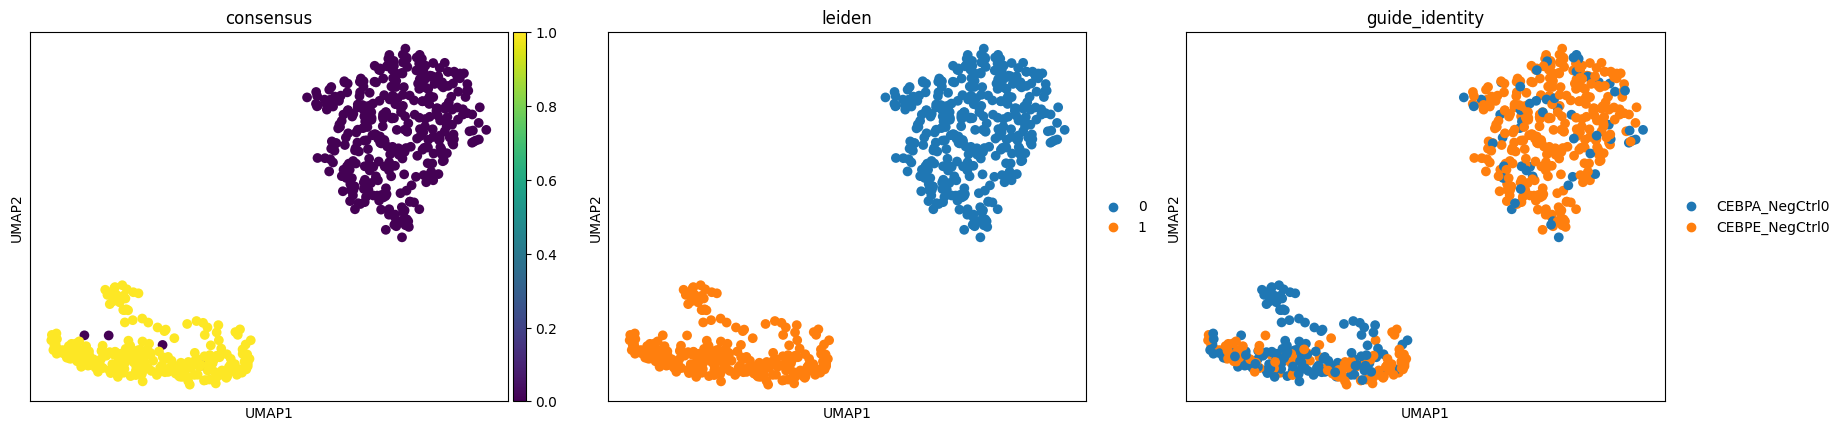

: 

: 

In [ ]:
sc.pl.umap(aa, color = ['consensus', "leiden",'guide_identity'], wspace=0.1)

In [ ]:
print(f" Intersection with GT1 I: {pd.merge(aa.var, net_gt_1, on=['source', 'target'], how='inner').shape}")
print(f" Intersection with GT2 I: {pd.merge(aa.var, net_gt_2, on=['source', 'target'], how='inner').shape}")

 Intersection with GT1 I: (79, 3)
 Intersection with GT2 I: (100, 3)


: 

: 

In [ ]:
help(d.filter_low_count_edges)

Help on function filter_low_count_edges in module postprocessing.downstreammain:

filter_low_count_edges(adata, min_mean_count=0.005)
    Filters edges with mean counts below a given threshold after calculating QC metrics.
    
    Parameters:
    -----------
    adata : AnnData
        The input AnnData object.
    min_mean_count : float
        Minimum mean count threshold to retain edges.
    
    Returns:
    --------
    AnnData
        Filtered AnnData object.



: 

: 

In [ ]:
aa = d.filter_low_count_edges(aa, min_mean_count=0.005)
aa

Filtered out 396027 genes (kept 288749).


View of AnnData object with n_obs × n_vars = 608 × 288749
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'source', 'target', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'guide_identity_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

: 

: 

In [ ]:
print(f" Intersection with GT1 I: {pd.merge(aa.var, net_gt_1, on=['source', 'target'], how='inner').shape}")
print(f" Intersection with GT2 I: {pd.merge(aa.var, net_gt_2, on=['source', 'target'], how='inner').shape}")

 Intersection with GT1 I: (70, 9)
 Intersection with GT2 I: (100, 9)


: 

: 

In [ ]:
gene_inter_adata = aa.copy()
print("Gene interaintion adata")
print(gene_inter_adata)
print("\n\n Gene expression adata")
adata = adata[gene_inter_adata.obs_names,:]
adata

Gene interaintion adata
AnnData object with n_obs × n_vars = 608 × 288749
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'source', 'target', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'guide_identity_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


 Gene expression adata


View of AnnData object with n_obs × n_vars = 608 × 2000
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden'
    var: 'Ensembl_ids', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'guide_identity_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

: 

: 

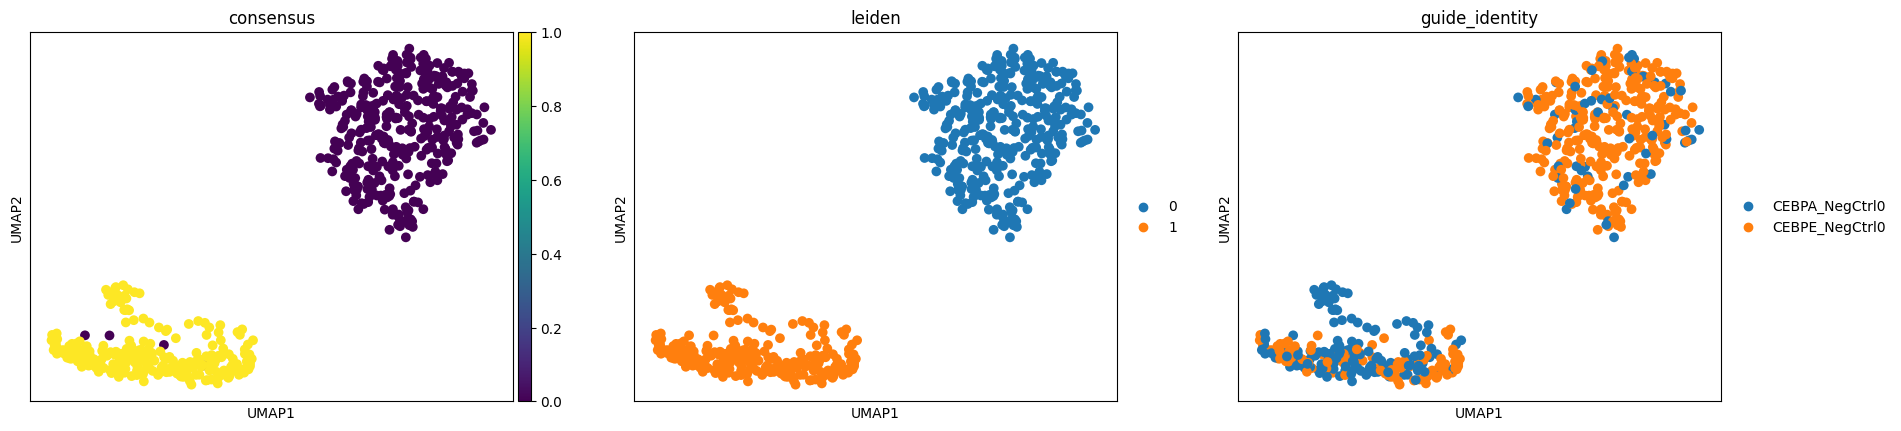

: 

: 

In [ ]:
sc.pl.umap(gene_inter_adata, color = ['consensus', 'leiden', 'guide_identity'])  

In [ ]:
help(d.filter_signatures_by_cluster)

Help on function filter_signatures_by_cluster in module postprocessing.downstreammain:

filter_signatures_by_cluster(adata, grn_adata, cluster, top_per_source, min_regulon_size, ncores=100)
    Group regulons by their source transcription factors and rank them based on differential activity between the current cluster and all other clusters. 
    The ranking reflects the magnitude and significance of activity shifts, prioritizing source genes whose downstream targets show distinct regulatory behavior in the specified cluster.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object containing the single-cell gene expression matrix and metadata.
        
    grn_adata : AnnData
        Annotated data object containing the gene regulatory network (GRN) data, which includes
        the edges between source genes and their target genes.
        
    cluster : str
        The cluster name (or label) within the Leiden clustering for which to select top genes and

: 

: 

In [ ]:
results_df, all_edges, data = d.filter_signatures_by_cluster(adata, gene_inter_adata, cluster="1", top_per_source=250, min_regulon_size=10, ncores=100)

588 source based groups are found
288437 edges are found


[1] "dimensions of the resulting scores"
[1] 608 588




: 

: 

In [ ]:
help(d.filter_grn_by_top_signatures)

Help on function filter_grn_by_top_signatures in module postprocessing.downstreammain:

filter_grn_by_top_signatures(grn_adata, results_df, all_edges, keep_top_ranked=100)
    Filter the top N ranked signatures based on P_Value.
    
    Parameters:
    -----------
    grn_adata : AnnData
        Full GRN AnnData object with `source` and `target` in .var and `leiden` in .obs.
    
    results_df : pd.DataFrame
        DataFrame containing ranked signatures with a 'P_Value' column and 'Signature' column.
    
    all_edges : pd.DataFrame
        DataFrame with 'source' and 'target' columns representing known or scored edges.
    
    keep_top_ranked : int, default=100
        Number of top-ranked signatures to use for filtering.
    
    Returns:
    --------
    grn_adata_filtered : AnnData
        Filtered AnnData object containing only top-ranked and matched edges.



: 

: 

In [ ]:
grn_adata_ = d.filter_grn_by_top_signatures(gene_inter_adata, results_df, all_edges, keep_top_ranked=100)
grn_adata_

top_n.shape: (100, 5)
Filtered edge count: 25000


AnnData object with n_obs × n_vars = 608 × 25000
    obs: 'leiden'
    var: 'source', 'target'

: 

: 

In [ ]:
print(f"grn_adata_ : {grn_adata_}")

print(f" Intersection with GT1 Adjusted_P_Value: {pd.merge(grn_adata_.var, net_gt_1, on=['source', 'target'], how='inner').shape}")
print(f" Intersection with GT2 Adjusted_P_Value: {pd.merge(grn_adata_.var, net_gt_2, on=['source', 'target'], how='inner').shape}")
print("\n")

grn_adata_ : AnnData object with n_obs × n_vars = 608 × 25000
    obs: 'leiden'
    var: 'source', 'target'
 Intersection with GT1 Adjusted_P_Value: (70, 2)
 Intersection with GT2 Adjusted_P_Value: (3, 2)




: 

: 

In [ ]:
help(d.create_regulon_activity_adata) 

Help on function create_regulon_activity_adata in module postprocessing.downstreammain:

create_regulon_activity_adata(data, grn_adata, grn_adata_)
    Convert processed regulon activity `data` into a new AnnData object aligned with GRN metadata.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame of regulon activity scores (e.g., UCell outputs). Columns are typically signature names.
    
    grn_adata : AnnData
        Full GRN AnnData object, used to inherit cell order, UMAP coordinates, and obs metadata.
    
    grn_adata_ : AnnData
        Filtered GRN AnnData object, used to select relevant source genes for columns.
    
    Returns:
    --------
    adata_regl : AnnData
        New AnnData object containing regulon activity with appropriate obs, var, and UMAP embeddings.



: 

: 

In [ ]:
adata_regl = d.create_regulon_activity_adata(data, gene_inter_adata, grn_adata_)
adata_regl

AnnData object with n_obs × n_vars = 608 × 100
    obs: 'barcode', 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_identity_', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    obsm: 'X_umap'

: 

: 

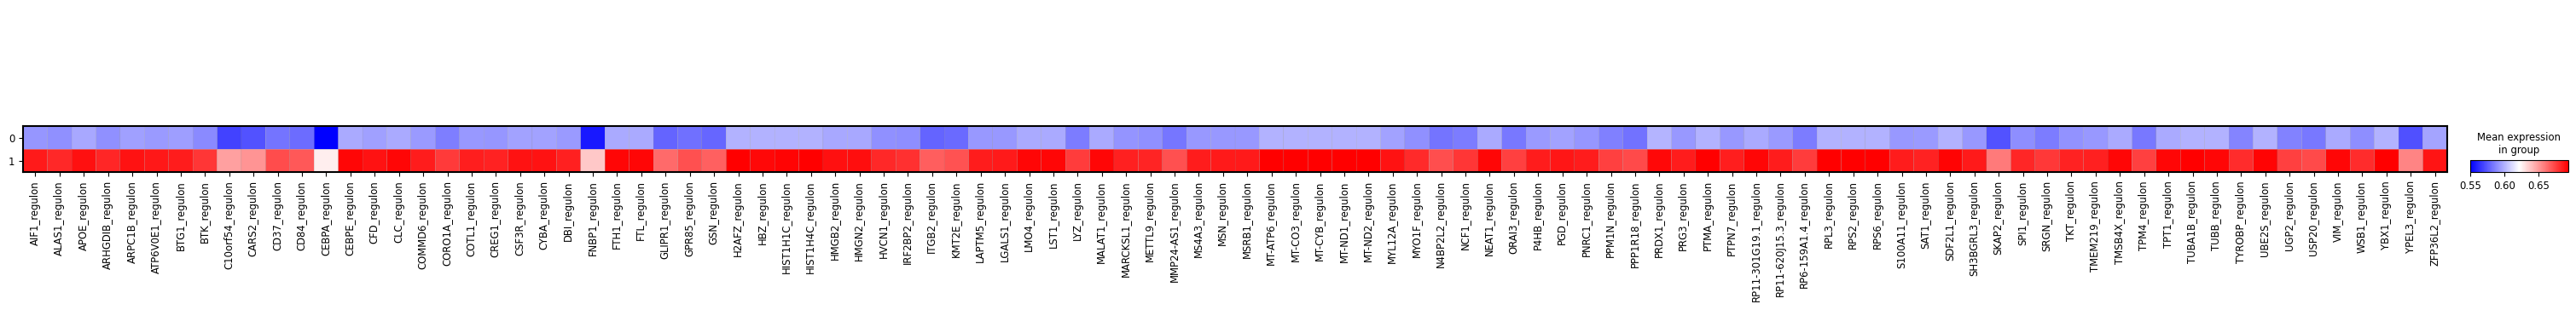

: 

: 

In [ ]:
marker_genes = list(adata_regl.var.index)

ax = sc.pl.matrixplot(adata_regl, marker_genes, groupby='leiden', cmap='bwr')

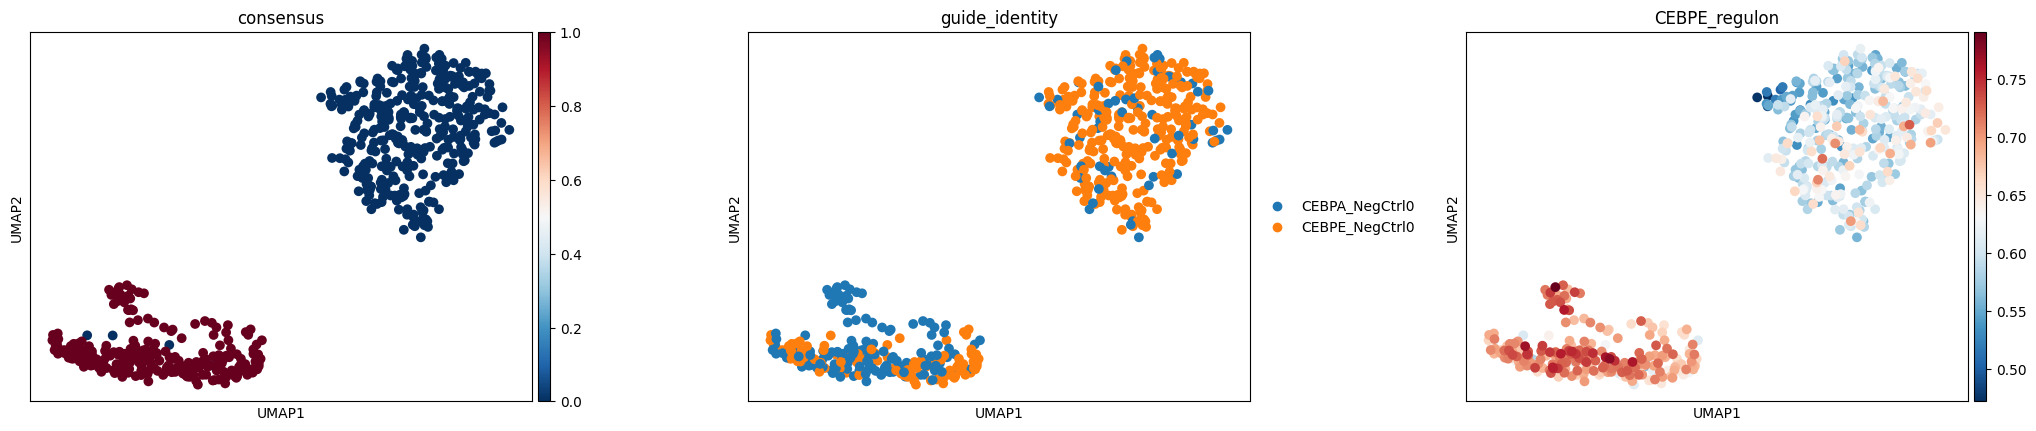

: 

: 

In [ ]:
sc.pl.umap(adata_regl, color = ['consensus', 'guide_identity',  "CEBPE_regulon"], wspace=0.3, cmap='RdBu_r')

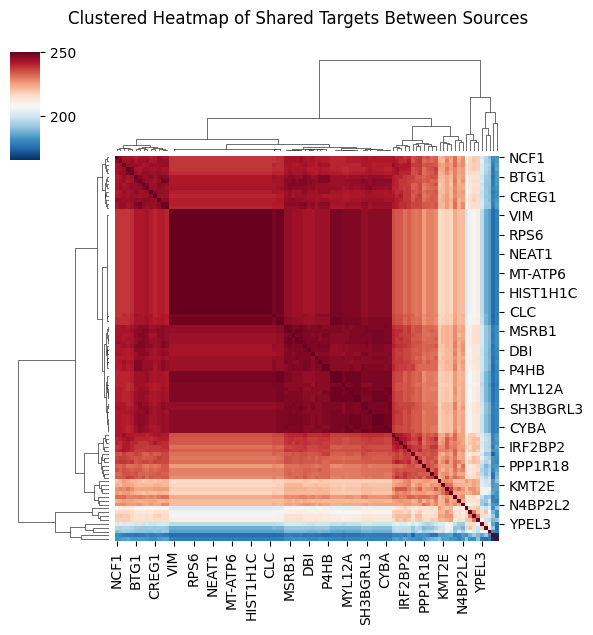

: 

: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Load your data
df = grn_adata_.var

# Step 1: Build mapping from source to set of targets
source_targets = df.groupby('source')['target'].apply(set)

# Step 2: Create similarity matrix
sources = source_targets.index.tolist()
shared_target_matrix = pd.DataFrame(0, index=sources, columns=sources)

# Step 3: Count shared targets for each source pair
for src1, src2 in combinations(sources, 2):
    shared = len(source_targets[src1] & source_targets[src2])
    shared_target_matrix.loc[src1, src2] = shared
    shared_target_matrix.loc[src2, src1] = shared

# Fill diagonal with number of targets per source
for src in sources:
    shared_target_matrix.loc[src, src] = len(source_targets[src])

# Step 4: Clustered heatmap
sns.clustermap(shared_target_matrix, cmap='RdBu_r', figsize=(6, 6), metric='euclidean', method='average')
plt.suptitle('Clustered Heatmap of Shared Targets Between Sources', y=1.05)
plt.show()

In [ ]:
tf_of_intrest = "CEBPE"

net_df = grn_adata_.var[grn_adata_.var["source"] == tf_of_intrest]
net_df.head(4)

,source,target
CEBPE_AAK1,CEBPE,AAK1
CEBPE_ACAA1,CEBPE,ACAA1
CEBPE_ACAP1,CEBPE,ACAP1
CEBPE_ACAP2,CEBPE,ACAP2


: 

: 

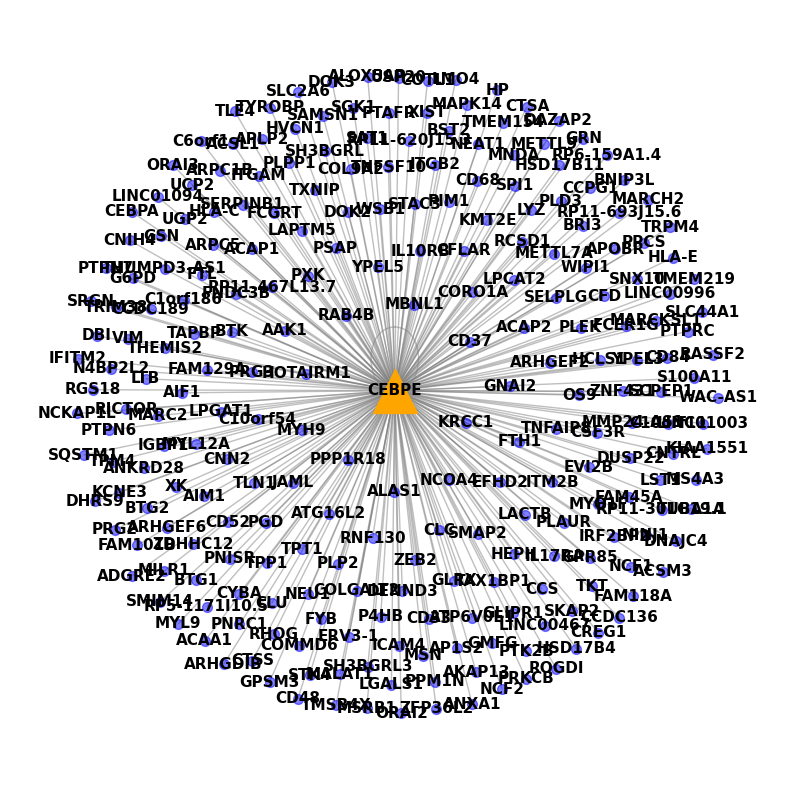

: 

: 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = net_df
G = nx.Graph()

for _, row in df.iterrows():
    G.add_edge(row['source'], row['target'])

pos = nx.spring_layout(G, seed=42)
source_nodes = df['source'].unique()

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if node not in source_nodes], node_size=50, node_color="blue", alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=source_nodes, node_size=1000, node_color="orange", alpha=1, node_shape='^')
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

plt.title('')
plt.axis('off')
plt.show()

In [ ]:
help(d.curate_network)

Help on function curate_network in module postprocessing.downstreammain:

curate_network(grn_adata_, organism='human', tfs=None)
    Load CollecTRI data for a specific organism, format it, and curate the network data
    based on the provided gene regulatory network (GRN) data.
    
    Parameters:
    -----------
    grn_adata_ : AnnData
        Annotated data object containing the gene regulatory network (GRN) data.
    
    organism : str, optional (default="human")
        The organism to retrieve data for from CollecTRI.
    
    tfs : list of str or None, optional (default=None)
        A list of transcription factors (source genes) to retain. If None, all TFs are used.
    
    Returns:
    --------
    net_df_curated : pandas.DataFrame
        The curated network DataFrame, containing the merged GRN data and CollecTRI interaction data.



: 

: 

In [ ]:
net_df_curated = d.curate_network(grn_adata_, organism="human", tfs=[tf_of_intrest])

: 

: 

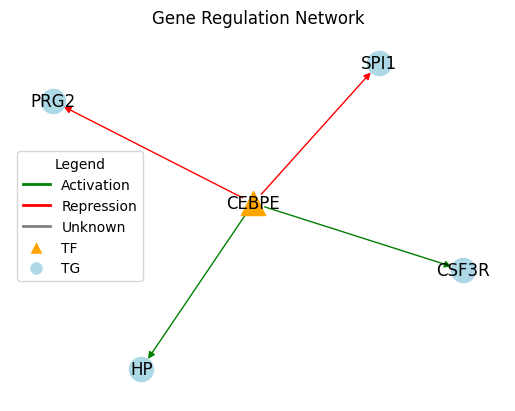

: 

: 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data
df = net_df_curated

# Create graph
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['source'], row['target'], type=row['mode'])

# Colors for edges
colors = {'Activation': 'green', 'Repression': 'red', 'Unknown': 'gray'}
edge_colors = [colors[G[u][v]['type']] for u, v in G.edges()]

# Positions
pos = nx.spring_layout(G, seed=42)

# Nodes
tf_nodes = set(df['source'])
nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_color='orange', node_shape='^')
nx.draw_networkx_nodes(G, pos, nodelist=set(G.nodes) - tf_nodes, node_color='lightblue')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True)

# Legend
plt.legend(handles=[
    Line2D([0], [0], color=c, lw=2, label=t) for t, c in colors.items()
] + [
    Line2D([0], [0], marker='^', color='w', label='TF', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='TG', markerfacecolor='lightblue', markersize=10)
], title='Legend')
plt.title("Gene Regulation Network")
plt.axis('off')
plt.show()

In [ ]:
# All
net_df_curated = d.curate_network(grn_adata_, organism="human")

: 

: 

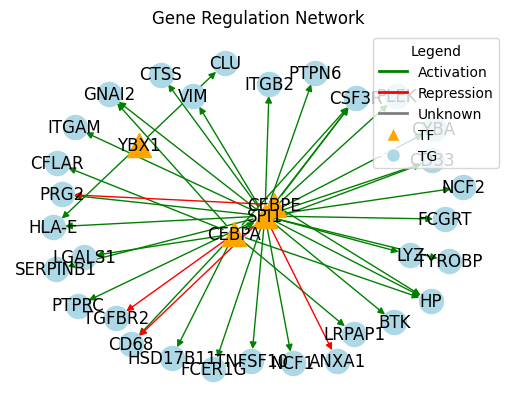

: 

: 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data
df = net_df_curated

# Create graph
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['source'], row['target'], type=row['mode'])

# Colors for edges
colors = {'Activation': 'green', 'Repression': 'red', 'Unknown': 'gray'}
edge_colors = [colors[G[u][v]['type']] for u, v in G.edges()]

# Positions
pos = nx.spring_layout(G, seed=42)

# Nodes
tf_nodes = set(df['source'])
nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_color='orange', node_shape='^')
nx.draw_networkx_nodes(G, pos, nodelist=set(G.nodes) - tf_nodes, node_color='lightblue')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True)

# Legend
plt.legend(handles=[
    Line2D([0], [0], color=c, lw=2, label=t) for t, c in colors.items()
] + [
    Line2D([0], [0], marker='^', color='w', label='TF', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='TG', markerfacecolor='lightblue', markersize=10)
], title='Legend')
plt.title("Gene Regulation Network")
plt.axis('off')
plt.show()

## Run

In [ ]:
aa = concatenate_cluster_anndatas(attributions)
aa.var["source"] = aa.var.index.str.split("_").str[0]
aa.var["target"] = aa.var.index.str.split("_").str[1]

: 

: 

In [ ]:
# Replace NaN values with 0 if needed

if isinstance(aa.X, np.ndarray):
    aa.X = np.nan_to_num(aa.X)
else:
    aa.X.data[np.isnan(aa.X.data)] = 0

: 

: 

In [ ]:
# Downstream processing defaults
DEFAULT_MIN_PERC = 10           # Minimum % of cells expressing a gene to keep it
DEFAULT_N_CLUSTERS = 2          # Number of clusters for filtering/labeling

# Edge filtering
DEFAULT_MIN_MEAN_COUNT = 0.005  # Minimum mean edge weight (strength) to retain

# Signature filtering
DEFAULT_TOP_PER_SOURCE = 200    # Max signatures to retain per source gene
DEFAULT_MIN_REGULON_SIZE = 10   # Minimum number of targets in a regulon to retain it
DEFAULT_NCORES = 100            # Number of parallel workers to use

# GRN filtering
DEFAULT_KEEP_TOP_RANKED = 100    # Top N signatures to keep from filtered results


: 

: 

In [ ]:
# Apply defaults explicitly for clarity
aa = d.downstream_recipe(aa, min_perc=DEFAULT_MIN_PERC, n_clusters=DEFAULT_N_CLUSTERS)

aa = d.filter_low_count_edges(aa, min_mean_count=DEFAULT_MIN_MEAN_COUNT)

gene_inter_adata = aa.copy()

# Align adata to gene interaction AnnData
adata = adata[gene_inter_adata.obs_names, :]

clusters_adata = []
for cluster_ in gene_inter_adata.obs["leiden"].unique():

    print(f"Cluster: {cluster_}")
    # Filter significant signatures
    results_df, all_edges, data = d.filter_signatures_by_cluster(
        adata,
        gene_inter_adata,
        cluster=cluster_,
        top_per_source=DEFAULT_TOP_PER_SOURCE,
        min_regulon_size=DEFAULT_MIN_REGULON_SIZE,
        ncores=DEFAULT_NCORES
    )

    # Keep only most significant interactions
    grn_adata_ = d.filter_grn_by_top_signatures(
        gene_inter_adata,
        results_df,
        all_edges,
        keep_top_ranked=DEFAULT_KEEP_TOP_RANKED
    )
    clusters_adata.append(grn_adata_)
    print(f"Cluster {cluster_} GRN size: {grn_adata_.shape}")



Removed 0 edges (kept 288749 edges).
Filtered out 0 genes (kept 288749).
Cluster: 0
588 source based groups are found
288437 edges are found


[1] "dimensions of the resulting scores"
[1] 608 588


top_n.shape: (100, 5)
Filtered edge count: 20000
Cluster 0 GRN size: (608, 20000)
Cluster: 1
588 source based groups are found
288437 edges are found


[1] "dimensions of the resulting scores"
[1] 608 588


top_n.shape: (100, 5)
Filtered edge count: 20000
Cluster 1 GRN size: (608, 20000)


: 

: 

In [ ]:
from anndata import concat

merged_grn_adata = concat(clusters_adata, axis=1)
merged_grn_adata

AnnData object with n_obs × n_vars = 608 × 40000
    var: 'source', 'target'

: 

: 

In [ ]:
print(f" Intersection with GT1 Adjusted_P_Value: {pd.merge(merged_grn_adata.var, net_gt_1, on=['source', 'target'], how='inner').shape}")
print(f" Intersection with GT2 Adjusted_P_Value: {pd.merge(merged_grn_adata.var, net_gt_2, on=['source', 'target'], how='inner').shape}")
print("\n")

 Intersection with GT1 Adjusted_P_Value: (70, 2)
 Intersection with GT2 Adjusted_P_Value: (86, 2)




: 

: 

: 

: 

: 

: 